### CIL on Google Colab

In this notebook, we show how to install [CIL](https://github.com/TomographicImaging/CIL) and all its dependencies on Google Colab with free access to GPU (16Gb). 

**Please note that Colab has recently upgraded its default runtime to Python version 3.10.**
The next version of Python (3.11) is scheduled to have its final regular bug fix release in April 2024. Previous version (Python 3.9) is available from the `Command Palette` (`Ctrl+Shift+P`) via the `Use fallback runtime version` command when connected to a runtime. This will be available until mid-May. See [here](https://medium.com/google-colab/colab-updated-to-python-3-10-27eb02daa162) for more information.

### Google Colab and Conda

Conda is not available by default on Google Colab. In order to install libraries using conda, we are going to use [Mamba](https://github.com/mamba-org/mamba), a fast cross-platform package manager from [Quantstack](https://quantstack.net/). First, we will need to install `conda` in google colab using [condacolab](https://github.com/conda-incubator/condacolab). Then, we will install cil and all its dependencies using `mamba`.

**Note** Due to different Python and Cudatoolkit versions in Google Colab the installation instructions for CIL will be different compared to [Install CIL](https://github.com/TomographicImaging/CIL#installation-of-cil).


### Install CIL with Google Colab Python=3.9 (recommended until mid-May)

According to this [Medium article](https://medium.com/google-colab/colab-updated-to-python-3-10-27eb02daa162), we can use Python 3.9 which is available from the `Command Palette` `(Ctrl+Shift+P)` via the `Use fallback runtime version` command when connected to a runtime. This will be available until mid-May. 

After you change the runtime version, you can check the python version with `!python3 --version`.

```bash
Python 3.9.16
```


In [1]:
!python --version

Python 3.8.13


### CIL Tomography backends

In CIL, we provide wrappers for two tomography backends:

  - [Astra-Toolbox](https://github.com/astra-toolbox/astra-toolbox) and 
  - [TIGRE](https://github.com/CERN/TIGRE). 
  
In order to install CIL with the above backends, we are going to follow the steps below depending on the default python version:

- If Python=3.9 is available: We can install `Astra` using mamba distribution using the following command:

```python
!mamba install -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=23.1.0 astra-toolbox ccpi-regulariser "ipywidgets<8"
```

- If Python=3.10:

```python
!mamba install -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=23.1.0 astra-toolbox ccpi-regulariser "ipywidgets<8"
!cp -r /usr/local/lib/python3.10/site-packages/astra_toolbox-2.0.0-py3.10-linux-x86_64.egg/astra /usr/local/lib/python3.10/site-packages/
```

- Python 3.9 or 3.10: For the TIGRE backend, we need to build the software locally following the [Python Instructions](https://github.com/CERN/TIGRE/blob/master/Frontispiece/python_installation.md). 
**In case, you want to install both backends the TIGRE installation step **must come first.**

**Note:** To use the **Astra** backend, please import the following: 

```python 
        from cil.plugins.astra import ProjectionOperator, FBP
```
    
**Note:** To use the **TIGRE** backend, please import the following: 

```python 
        from cil.plugins.tigre import ProjectionOperator, FBP
```

### Install [TIGRE](https://github.com/CERN/TIGRE) tomography backend (Optional)

We clone the TIGRE repository and change the directory to the python installation. Then, we run the `setup.py` script and check if the `example.py` demo run without any errors.

**Note:** If you want to use both TIGRE and ASTRA, the installation steps below must come first.


In [1]:
!git clone https://github.com/CERN/TIGRE.git 
%cd TIGRE/Python 
!python setup.py install  
!python example.py 

### Install Conda in google colab

Google colab does not have `conda`. We install `conda` using the `condacolab` library.

In [ ]:
!pip install -q condacolab

In [ ]:
import condacolab

### Please wait for the kernel to restart

In [ ]:
condacolab.install()

### Install ASTRA and CIL with all the required libraries

- Python 3.9: 

```python
!mamba install -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=23.1.0 astra-toolbox ccpi-regulariser "ipywidgets<8" --quiet

```

- Python 3.10: 

```python
!mamba install -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=23.1.0 astra-toolbox ccpi-regulariser "ipywidgets<8"
!cp -r /usr/local/lib/python3.10/site-packages/astra_toolbox-2.0.0-py3.10-linux-x86_64.egg/astra /usr/local/lib/python3.10/site-packages/
```

In [6]:
# python 3.9
!mamba install -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=23.1.0 astra-toolbox ccpi-regulariser "ipywidgets<8" --quiet

# python 3.10
# !mamba install -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=23.0.1 astra-toolbox ccpi-regulariser "ipywidgets<8" --quiet
# !cp -r /usr/local/lib/python3.10/site-packages/astra_toolbox-2.0.0-py3.10-linux-x86_64.egg/astra /usr/local/lib/python3.10/site-packages/

### Limited Angle Tomography Reconstruction

In this notebook, we use a three-dimensional parallel-beam X-ray CT real dataset from Beamline I13-2, Diamond Light Source, Harwell, UK. 

The sample consisted of a 0.5 mm aluminium cylinder with a piece of steel wire embedded in a small drilled hole. A droplet of salt water was placed on top, causing corrosion to form hydrogen bubbles. The dataset, which was part of a fast time-lapse experiment, consists of 91 projections over 180, originally acquired as size 2560-by-2160 pixels, but provided in [here](https://github.com/DiamondLightSource/Savu/blob/master/test_data/data/24737_fd.nxs) downsampled to 160-by-135 pixels.

We reconstruct this dataset using analytic and iterative reconstruction methods with a limited number of projections:

* the Filtered Back Projection (FBP) algorithm,

* Total variation (TV) regularisation under a non-negativity constraint

    <a id='tv_reg'></a>
    \begin{equation}
    \underset{u}{\operatorname{argmin}} \frac{1}{2} \| A u - d\|^{2}_{2} + \alpha\,\mathrm{TV}(u) + \mathbb{I}_{\{u\geq0\}}(u)
    \tag{1}
    \end{equation}

    where,

    * d is a noisy sinogram and
    * $A$ is the Projection operator. (TIGRE or Astra)

### Import libraries

In [1]:
from cil.framework import  AcquisitionGeometry
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector
from cil.optimisation.functions import L2NormSquared
from cil.optimisation.algorithms import PDHG
from cil.utilities.display import show2D, show_geometry
from cil.utilities import dataexample
from cil.plugins.ccpi_regularisation.functions import FGP_TV

import matplotlib.pyplot as plt

import numpy as np

### Select tomography backend: ASTRA or TIGRE 


In [2]:
from cil.plugins.astra import ProjectionOperator, FBP # Astra Backend
# # from cil.plugins.tigre import ProjectionOperator, FBP # TIGRE backend

In [3]:
import cil.version
print(cil.version.version)

22.2.0


### Load Dataset

In [4]:
data_raw = dataexample.SYNCHROTRON_PARALLEL_BEAM_DATA.get(data_dir="/usr/local/share/cil")

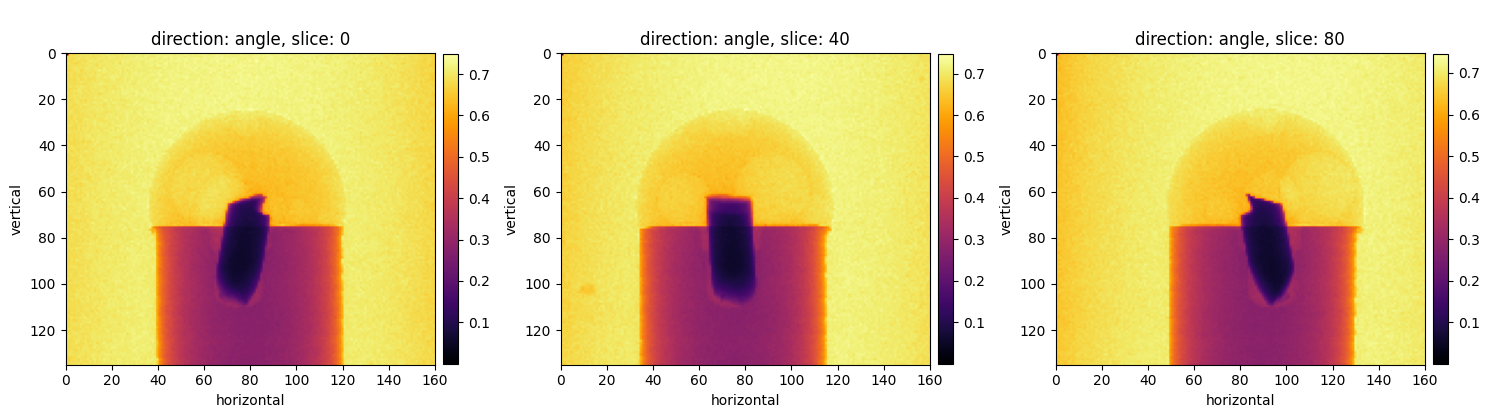

In [5]:
show2D(data_raw, slice_list=[('angle',0), ('angle', 40), ('angle',80)], \
        cmap="inferno", num_cols=3, origin='upper')

### Preprocess Sinogram data

In the code above, we preprocess our acquired data:

- Convert to Absorption using Lambert-Beer law
- Correct centre of rotation artifacts
- Limit the number of angles

In [6]:
background = data_raw.get_slice(vertical=20).mean()
data_raw /= background

# Lambert-Beer law
data_abs = TransmissionAbsorptionConverter()(data_raw)
data_crop = Slicer(roi={'vertical': (1, None)})(data_abs)

# Reorder the shape of sinogram only if astra backend is used
data_crop.reorder(order='astra')

# Correct centre of rotation artifacts
data_centred = CentreOfRotationCorrector.xcorrelation()(data_crop)

# Reduce number of projections
data_centred = Slicer(roi={'angle': (0, 90, 6), 'horizontal': (20,140,1)})(data_centred)

# Get acquisition geometry
ag = data_centred.geometry

# Get image geometry
ig = ag.get_ImageGeometry()



### Show Acquisition Geometry

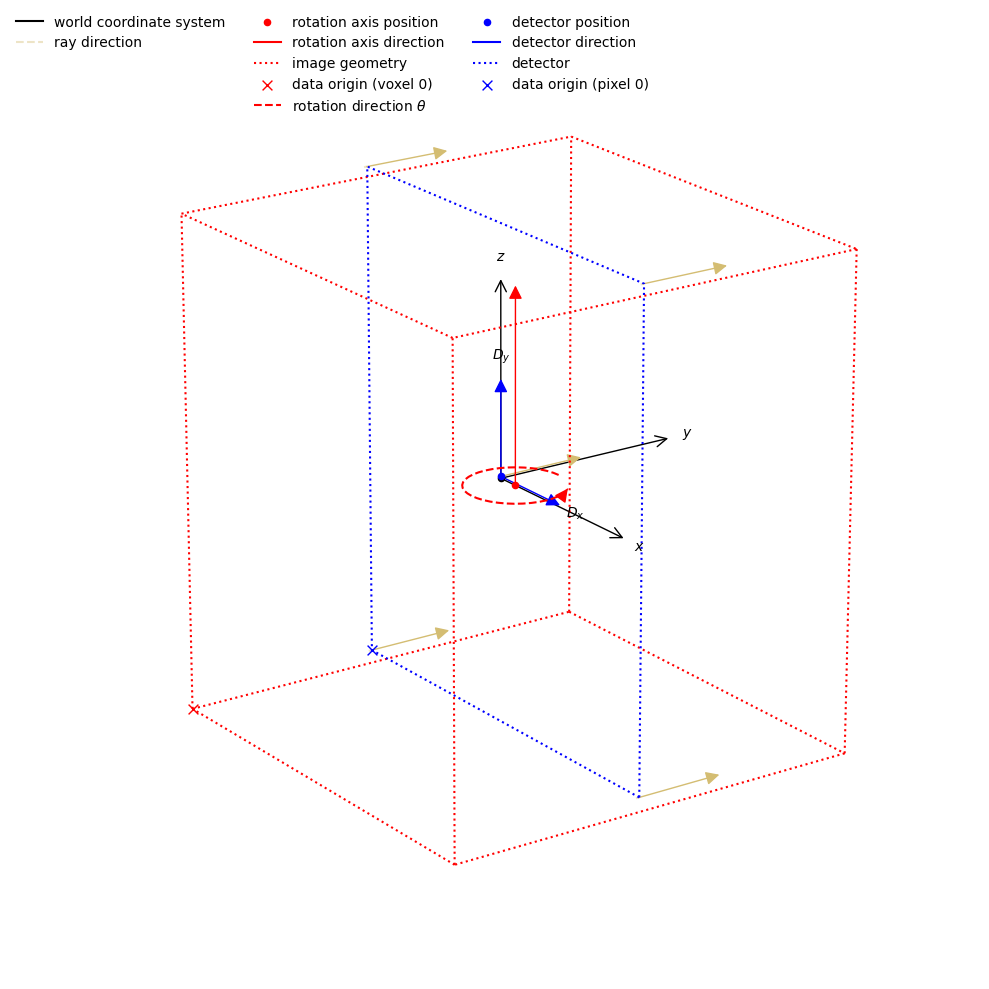

In [7]:
show_geometry(ag)

### Run 3D FBP reconstruction

**TIGRE backend: If you use TIGRE, please reorder the data using** `data_centred.reorder("tigre")`. 

In [8]:
fbp_recon = FBP(ig, ag, device='gpu')(data_centred)

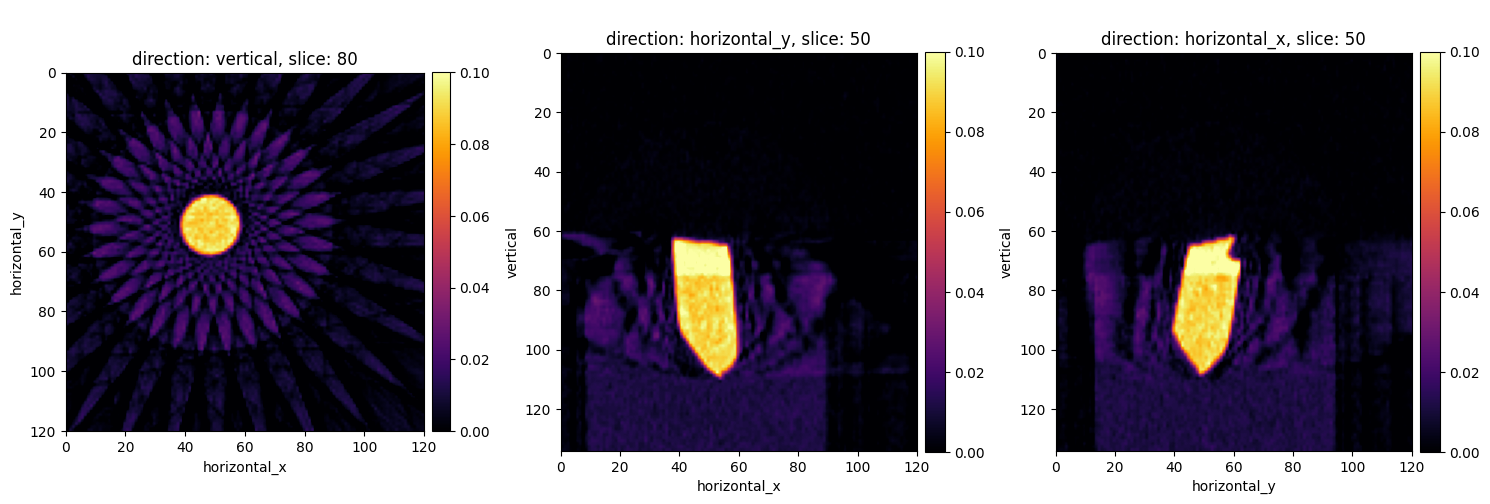

In [9]:
# visualise reconstruction results
show2D(fbp_recon, slice_list=[('vertical',80), 
                              ('horizontal_y',50), 
                              ('horizontal_x',50)], \
        cmap="inferno", num_cols=3, size=(15,15), 
       fix_range = (0,0.1),
       origin='upper-left')


### Total variation reconstruction

For the total variation (TV) regularisation under a non-negativity constraint, we use
the [Primal-Dual Hybrid Gradient (PDHG)]([ChambollePock](https://link.springer.com/article/10.1007/s10851-010-0251-1)). The PDHG algorithm solves the following problem:

$$\underset{x\in \mathbb{X} }{\operatorname{argmin}} f(Kx) + g(x).$$

In our case, we have $K=A$, i.e., our projection operator 
```A = ProjectionOperator(ig, ag, device="gpu")```

**Note: cpu option is not available for the TIGRE backend**

The fidelity term is formed using $f(z) = \frac{1}{2}\|z - d\|^{2}$

`F = 0.5*L2NormSquared(b=data_centred)
`

Finally, the function $g$ is the proximal operator of the total variation with non-negativity constraint, i.e.,

$$\underset{v}{\operatorname{argmin}} \frac{1}{2}\|v-x\|^{2} + \alpha\mathrm{TV}(v) + \mathbb{I}_{\{v>0\}}(v)$$

The above problem is solve using the [FISTA](https://ieeexplore.ieee.org/document/4959678) algorithm, i.e., Fast Gradient Projection algorithm.

`G = alpha * FGP_TV(device = "gpu")`

**Note: In CIL, we provide wrappers from the [CCPi-Regularisation Toolkit](https://github.com/vais-ral/CCPi-Regularisation-Toolkit) in order to compute efficiently (CPU/GPU) different proximal operators.**


In [14]:
# Projection Operator
A = ProjectionOperator(ig, ag, device="gpu")

# Fidelity term
F = 0.5*L2NormSquared(b=data_centred)

# TV regularization
alpha = 0.2
G = alpha * FGP_TV(nonnegativity=True, device = "gpu")

# setup and run PDHG algorithm
pdhg = PDHG(initial=ig.allocate(), f=F, g=G, operator=A, 
            update_objective_interval=10,max_iteration=100)
pdhg.run()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          4.05871e+04
       10        100         0.198          8.72076e+02
       20        100         0.188          2.56213e+02
       30        100         0.185          2.18275e+02
       40        100         0.186          2.12919e+02
       50        100         0.187          2.11025e+02
       60        100         0.186          2.10416e+02
       70        100         0.186          2.10225e+02
       80        100         0.187          2.10153e+02
       90        100         0.187          2.10137e+02
      100        100         0.187          2.10124e+02
-------------------------------------------------------
      100        100         0.187          2.10124e+02
Stop criterion has been reached.



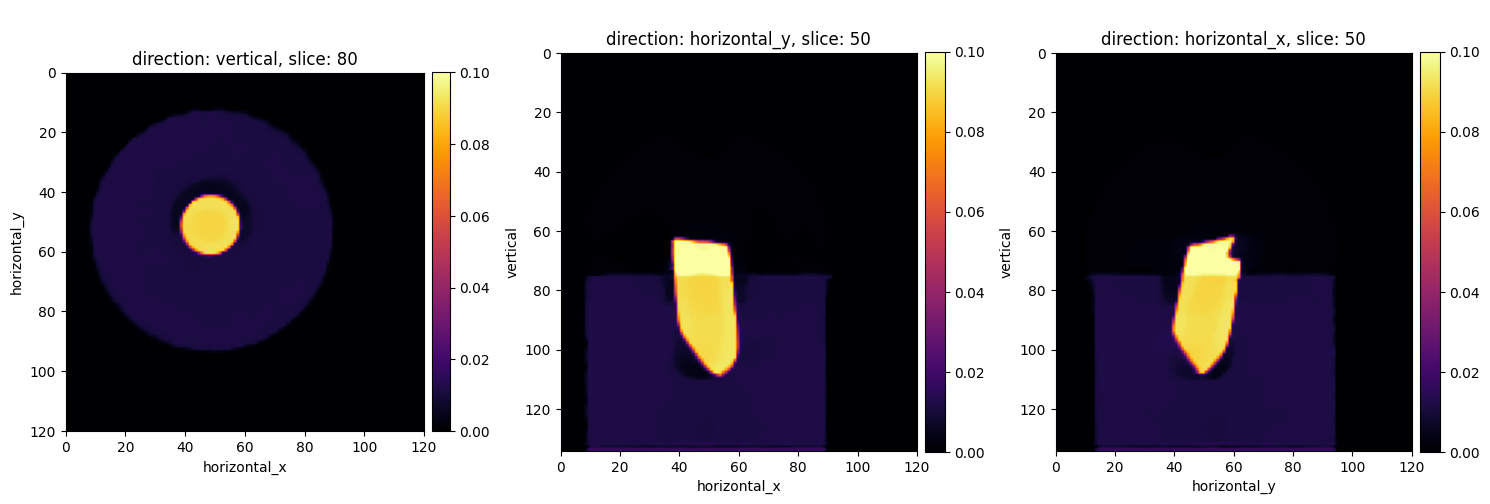

In [15]:
show2D(pdhg.solution, slice_list=[('vertical',80), 
                              ('horizontal_y',50), 
                              ('horizontal_x',50)], \
        cmap="inferno", num_cols=3,
        fix_range=(0,0.1), origin='upper')

### Other tomography demos on Google Colab

To try more demos on Google Colab, please visit our [CIL-Demos](https://github.com/TomographicImaging/CIL-Demos) repository and load one of our notebooks to the Google Colab platform and repeat the installation steps above. 

